# explore the extended kalman filter data

````
Data Flow:
1) The measuremennt processor/matlab simulator is generating the FUSION .txt file:
	"data/obj_pose-laser-radar-synthetic-ukf-input.txt";
	OR
	"../matlab_examples/obj_pose-laser-radar-synthetic-ukf-input.txt";

The Input file format is:
#L(for laser) meas_px meas_py timestamp gt_px gt_py gt_vx gt_vy
#R(for radar) meas_rho meas_phi meas_rho_dot timestamp gt_px gt_py gt_vx gt_vy

Example:
R	8.60363	0.0290616	-2.99903	1477010443399637	8.6	0.25	-3.00029	0
L	8.45	0.25	1477010443349642	8.45	0.25	-3.00027	0
	
2) The EKF Algorithm reads form file reads all the lines and generates measurement structures
3) The MeasurementProcessor() is called with individual measurements (one by one). The results are saved
(Attention: no file processing routines are used inside MeasurementProcessor() all the file processing routines are in the main function
So the data read/write is decoupled from the algorithm
4) The results are saved in an output file:
"data/obj_pose-laser-radar-ekf-output.txt"

Output file format:
est_px est_py est_vx est_vy meas_px meas_py gt_px gt_py gt_vx gt_vy

Example:
4.53271	0.279	-0.842172	53.1339	4.29136	0.215312	2.28434	0.226323
43.2222	2.65959	0.931181	23.2469	4.29136	0.215312	2.28434	0.226323
````

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
import math
import random
import csv

%matplotlib inline

In [108]:
raw_data = []
with open('data/data-1.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        raw_data.append(row)

In [109]:
def polar_to_cartesian(polar_x):
    rho, phi, drho = polar_x[0], polar_x[1], polar_x[2]
    
    px = rho * math.cos(phi)
    py = rho * math.sin(phi)
    vx = drho * math.cos(phi)
    vy = drho * math.sin(phi)
    
    return np.array([px, py, vx, vy])
    

In [110]:
def cartesian_to_polar(cartesian_x_):
    THRESH = 0.0001;
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    drho = 0
    if rho > THRESH: drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

In [111]:
def get_jacobian_from_state(cartesian_x_):
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    
    
    px2_plus_py2 = px**2 + py**2
    on_sqrt = math.sqrt(px2_plus_py2)
    on_3_per_2 = math.pow(px2_plus_py2, 3/2)
    
    vi1 = py * (vx*py - vy*px) / on_3_per_2
    vi2 = px * (vy*px - vx*py) / on_3_per_2
    
    Hj = np.array([[px / on_sqrt,        py / on_sqrt,      0,             0]
                  ,[-py / px2_plus_py2,  px / px2_plus_py2, 0,             0]
                  ,[vi1,                 vi2,               px / on_sqrt,  py / on_sqrt ]
                  ])
    return Hj
    
    

In [112]:
class Kalman():
    def __init__(self):
        self.x = np.array([[0], 
                           [0],
                           [0],
                           [0]]) # initial state (location and velocity)
        self.inited = False
        self.reset()
        
    def reset(self):
        self.P = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1000, 0], 
                           [0, 0, 0, 1000]]).astype(float) # initial uncertainty
        
        self.u = np.array([[0], [0], [0], [0]]) # external motion
        
        self.F = np.array([[1, 0, 1, 0], 
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]).astype(float) # next state function
               
        self.I = np.array([[1, 0, 0, 0], 
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # identity matrix      
        
    def start(self, x_):
        x__ = np.array(x_).reshape(4,1)    
        self.x = x__
        print (x__, self.x)
        self.inited = True
        
    def feed_meas_L(self, measurement): 
        #print('------ L ---------')
        if (self.inited == False):
            self.start(measurement)
            return
        
        z = np.array(measurement).reshape((2,-1)) # z - measurement matrix
        H = np.array([[1, 0, 0, 0] # X to measurement mapping matrix (H * x = measurement)
                     ,[0, 1, 0, 0]])
        R = np.array([[0.01, 0], 
                     [0, 0.01]])
        
        Hx = H.dot(self.x)
    
        self.process_meas(z, H, Hx, R)
        

    def feed_meas_R(self, measurement):
        #print('------ R ---------')
        if (self.inited == False):
            self.start(polar_to_cartesian(measurement))
            return
        
        z = np.array(measurement).reshape((3,-1)) # z - measurement matrix
        H = get_jacobian_from_state(polar_to_cartesian(measurement))
        R =  np.array([[0.01, 0, 0], 
                     [0, 1.0e-6, 0], 
                     [0, 0, 0.01]])
        
        Hx = cartesian_to_polar(self.x).reshape(3,1)
        
        self.process_meas(z, H, Hx, R)

    def process_meas(self, z, H, Hx, R):

        y = z - Hx # error : previous state - measurement X measurement matrix
        #print ('z', z)
        #print ('y', y)
        S = H.dot(self.P).dot(H.transpose()) + R
        #print ('S', S)
        K = self.P.dot(H.transpose()).dot(np.linalg.inv(S)) # kalman gain
        #print('K', K)
        self.x = self.x + K.dot(y) # new state : x + kalman gain X error
        #print ('self.x', self.x)
        self.P = np.dot((self.I - K.dot(H)), self.P) # + self.Q # adjusting uncertainty covaria       
        #print ('self.P', self.P)
        
    def predict_next_state(self): 
        self.x = np.dot(self.F, self.x) #+ self.u # new state : movement matrix X current state + movement
        self.P = np.dot(np.dot(self.F, self.P), self.F.transpose()) + self.Q # adjusting covar matrix
       
    def update_F(self, dt):
        self.F[0, 2] = dt;
        self.F[1, 3] = dt; 
        
    def update_Q(self, dt):
        ##### covariance uncertainity Q
        ##### values coming from decomposing the acceleration component in the kin.equatations

        dt2 = dt * dt
        dt3 = dt * dt2
        dt4 = dt * dt3

        x, y = 5,5

        r11 = dt4 * x / 4
        r13 = dt3 * x / 2
        r22 = dt4 * y / 4
        r24 = dt3 * y /  2
        r31 = dt3 * x / 2 
        r33 = dt2 * x
        r42 = dt3 * y / 2
        r44 = dt2 * y

        self.Q = np.array([[r11, 0, r13, 0],
                      [0, r22, 0, r24],
                      [r31, 0, r33, 0], 
                      [0, r42, 0, r44]])    
    
    
        
        
def calculate_RMSE(truth_, pred_):
    truth = np.array(truth_).reshape(-1,4).astype(float)   
    pred = np.array(pred_).reshape(-1,4).astype(float)
    
    truth = truth[:,0:2]
    pred = pred[:,0:2]
    return np.sqrt(np.sum((truth - pred)**2, axis=1))




pred_list = []
l_meas_list = []
r_meas_list = []
truth_list = []
i = 1
k = Kalman()
timestamp = 0
for c,p in enumerate(raw_data):
    i += 1
    if p[0] == 'L':
        ## lidar
        x, y = float(p[1]), float(p[2])
        dt = (int(p[3]) - timestamp) / 100000        
        #dt += random.random() / 10 - 0.05
        timestamp = int(p[3])

        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()
        k.feed_meas_L([x,y])
        
        l_meas_list.append([x,y])
        
        pred_list.append(k.x)
        truth_list.append(p[4:8])
        
        
        
        
        ####################
        ####################
        print("-----------------------------------------------------------")
        print("#", c+1, ":", int(p[3]))
        print("-----------------------------------------------------------")   
        print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", x, y))
        pred_flat = k.x.flatten()
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'
              .format("PREDICTION:",pred_flat[0], pred_flat[1], pred_flat[2], pred_flat[3] ))
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:",float(p[4]), float(p[5]),float(p[6]), float(p[7])))  
        
    else:
        #continue
        ## radar
        rho, phi, drho = float(p[1]), float(p[2]), float(p[3])
        dt = (int(p[4]) - timestamp) / 100000
        
        dt += random.random() / 10 - 0.05

        timestamp = int(p[4])
        
        k.update_Q(dt)
        k.update_F(dt)
        k.predict_next_state()        
        cartesian = polar_to_cartesian([rho, phi, drho])
        #k.feed_meas_L([cartesian[0], cartesian[1]])
        k.feed_meas_R([rho, phi, drho])
                        
        r_meas_list.append(polar_to_cartesian([rho, phi, drho]))
        
        pred_list.append(k.x)
        truth_list.append(p[5:9])

        ####################
        ####################
        print("-----------------------------------------------------------")
        print("#", c+1, ":", int(p[4]))
        print("-----------------------------------------------------------")   
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |'.format('RADAR', rho, phi, drho))
        pred_flat = k.x.flatten()
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'
              .format("PREDICTION:",pred_flat[0], pred_flat[1], pred_flat[2], pred_flat[3] ))
        print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:",float(p[5]), float(p[6]),float(p[7]), float(p[8])))  
        
      
        


pred_list = np.array(pred_list)
l_meas_list = np.array(l_meas_list)
r_meas_list = np.array(r_meas_list)
truth_list = np.array(truth_list)

RMSE = calculate_RMSE(truth_list, pred_list)
print ('RMSE', np.sum(RMSE) / len(RMSE))

[[ 8.46291875]
 [ 0.24346237]
 [-3.03909268]
 [-0.08742902]] [[ 8.46291875]
 [ 0.24346237]
 [-3.03909268]
 [-0.08742902]]
-----------------------------------------------------------
# 1 : 1477010443399637
-----------------------------------------------------------
RADAR           |    8.466 |    0.029 |   -3.040 |
PREDICTION:     |    8.463 |    0.243 |   -3.039 |   -0.087 |
TRUTH:          |    8.600 |    0.250 |   -3.000 |    0.000 |
-----------------------------------------------------------
# 2 : 1477010443449633
-----------------------------------------------------------
LIDAR:          |    8.448 |    0.252 |
PREDICTION:     |    8.448 |    0.252 |   -3.039 |   -0.087 |
TRUTH:          |    8.450 |    0.250 |   -3.000 |    0.000 |
-----------------------------------------------------------
# 3 : 1477010443499690
-----------------------------------------------------------
RADAR           |    8.571 |    0.028 |   -0.011 |
PREDICTION:     |    8.553 |    0.239 |   -0.003 |   -0.032

# 99 : 1477010448579678
-----------------------------------------------------------
RADAR           |   15.413 |   -0.877 |    0.867 |
PREDICTION:     |    9.841 |  -11.842 |    0.310 |   -0.852 |
TRUTH:          |    9.800 |  -11.750 |   -1.000 |   -2.001 |
-----------------------------------------------------------
# 100 : 1477010448629664
-----------------------------------------------------------
LIDAR:          |    9.749 |  -11.844 |
PREDICTION:     |    9.777 |  -11.885 |   -0.505 |    0.491 |
TRUTH:          |    9.750 |  -11.850 |   -1.000 |   -2.001 |
-----------------------------------------------------------
# 101 : 1477010448679644
-----------------------------------------------------------
RADAR           |   15.405 |   -0.890 |    1.778 |
PREDICTION:     |    9.753 |  -12.043 |    0.867 |   -1.529 |
TRUTH:          |    9.700 |  -12.000 |   -1.000 |   -3.001 |
-----------------------------------------------------------
# 102 : 1477010448729625
---------------------------

# 279 : 1477010458244771
-----------------------------------------------------------
RADAR           |    6.912 |   -0.334 |    0.909 |
PREDICTION:     |    6.502 |   -2.245 |    0.795 |   -0.472 |
TRUTH:          |    6.350 |   -2.200 |    0.000 |   -2.728 |
-----------------------------------------------------------
# 280 : 1477010458299761
-----------------------------------------------------------
LIDAR:          |    6.369 |   -2.339 |
PREDICTION:     |    6.411 |   -2.352 |   -0.969 |    0.054 |
TRUTH:          |    6.350 |   -2.350 |    0.000 |   -2.728 |
-----------------------------------------------------------
# 281 : 1477010458354753
-----------------------------------------------------------
RADAR           |    6.757 |   -0.382 |    1.232 |
PREDICTION:     |    6.320 |   -2.541 |    0.962 |   -0.832 |
TRUTH:          |    6.350 |   -2.550 |    0.000 |   -3.637 |
-----------------------------------------------------------
# 282 : 1477010458409745
--------------------------

# 400 : 1477010464679655
-----------------------------------------------------------
LIDAR:          |    4.452 |  -10.442 |
PREDICTION:     |    4.422 |  -10.373 |    0.404 |   -0.665 |
TRUTH:          |    4.450 |  -10.450 |    0.000 |    2.000 |
-----------------------------------------------------------
# 401 : 1477010464729676
-----------------------------------------------------------
RADAR           |   11.144 |   -1.159 |   -2.223 |
PREDICTION:     |    4.420 |  -10.136 |   -0.688 |    2.075 |
TRUTH:          |    4.500 |  -10.300 |    1.000 |    2.999 |
-----------------------------------------------------------
# 402 : 1477010464779698
-----------------------------------------------------------
LIDAR:          |    4.553 |  -10.134 |
PREDICTION:     |    4.506 |  -10.030 |    0.836 |   -1.251 |
TRUTH:          |    4.550 |  -10.150 |    1.000 |    2.999 |
-----------------------------------------------------------
# 403 : 1477010464834700
-------------------------------------

-----------------------------------------------------------
# 564 : 1477010473309637
-----------------------------------------------------------
LIDAR:          |    8.333 |   -6.746 |
PREDICTION:     |    8.430 |   -6.821 |   -1.835 |    1.229 |
TRUTH:          |    8.350 |   -6.750 |    1.822 |   -2.733 |
-----------------------------------------------------------
# 565 : 1477010473364703
-----------------------------------------------------------
RADAR           |   10.960 |   -0.688 |    2.425 |
PREDICTION:     |    8.501 |   -6.984 |    1.752 |   -1.618 |
TRUTH:          |    8.400 |   -6.900 |    0.908 |   -2.724 |
-----------------------------------------------------------
# 566 : 1477010473419770
-----------------------------------------------------------
LIDAR:          |    8.444 |   -7.039 |
PREDICTION:     |    8.519 |   -7.100 |   -1.419 |    0.978 |
TRUTH:          |    8.450 |   -7.050 |    0.908 |   -2.724 |
-----------------------------------------------------------
# 

PREDICTION:     |   11.192 |   -1.635 |    0.761 |    0.153 |
TRUTH:          |   11.250 |   -1.650 |   -0.909 |    2.727 |
-----------------------------------------------------------
# 729 : 1477010482194770
-----------------------------------------------------------
RADAR           |   11.435 |   -0.133 |   -0.410 |
PREDICTION:     |   11.314 |   -1.515 |   -0.360 |    0.299 |
TRUTH:          |   11.250 |   -1.500 |    0.000 |    2.723 |
-----------------------------------------------------------
# 730 : 1477010482249852
-----------------------------------------------------------
LIDAR:          |   11.262 |   -1.348 |
PREDICTION:     |   11.252 |   -1.348 |    0.093 |    0.296 |
TRUTH:          |   11.250 |   -1.350 |    0.000 |    2.723 |
-----------------------------------------------------------
# 731 : 1477010482304826
-----------------------------------------------------------
RADAR           |   11.375 |   -0.105 |   -1.321 |
PREDICTION:     |   11.221 |   -1.181 |   -1.248 | 

PREDICTION:     |    4.390 |   -9.957 |   -0.671 |    2.122 |
TRUTH:          |    4.500 |  -10.200 |    1.000 |    2.999 |
-----------------------------------------------------------
# 900 : 1477010491429693
-----------------------------------------------------------
LIDAR:          |    4.556 |  -10.045 |
PREDICTION:     |    4.505 |   -9.929 |    0.940 |   -1.567 |
TRUTH:          |    4.550 |  -10.050 |    1.000 |    2.999 |
-----------------------------------------------------------
# 901 : 1477010491479780
-----------------------------------------------------------
RADAR           |   10.860 |   -1.136 |   -2.263 |
PREDICTION:     |    4.549 |   -9.796 |   -0.782 |    2.085 |
TRUTH:          |    4.600 |   -9.900 |    0.998 |    2.995 |
-----------------------------------------------------------
# 902 : 1477010491529867
-----------------------------------------------------------
LIDAR:          |    4.658 |   -9.751 |
PREDICTION:     |    4.609 |   -9.650 |    0.811 |   -1.123 |


LIDAR:          |    8.332 |   -6.870 |
PREDICTION:     |    8.390 |   -6.912 |   -1.160 |    0.627 |
TRUTH:          |    8.350 |   -6.850 |    0.909 |   -1.818 |
-----------------------------------------------------------
# 1063 : 1477010500029640
-----------------------------------------------------------
RADAR           |   11.172 |   -0.695 |    2.791 |
PREDICTION:     |    8.640 |   -7.190 |    2.064 |   -1.803 |
TRUTH:          |    8.400 |   -7.000 |    1.000 |   -3.000 |
-----------------------------------------------------------
# 1064 : 1477010500079634
-----------------------------------------------------------
LIDAR:          |    8.458 |   -7.153 |
PREDICTION:     |    8.579 |   -7.249 |   -1.826 |    1.229 |
TRUTH:          |    8.450 |   -7.150 |    1.000 |   -3.000 |
-----------------------------------------------------------
# 1065 : 1477010500129657
-----------------------------------------------------------
RADAR           |   10.987 |   -0.703 |    2.840 |
PREDICTI

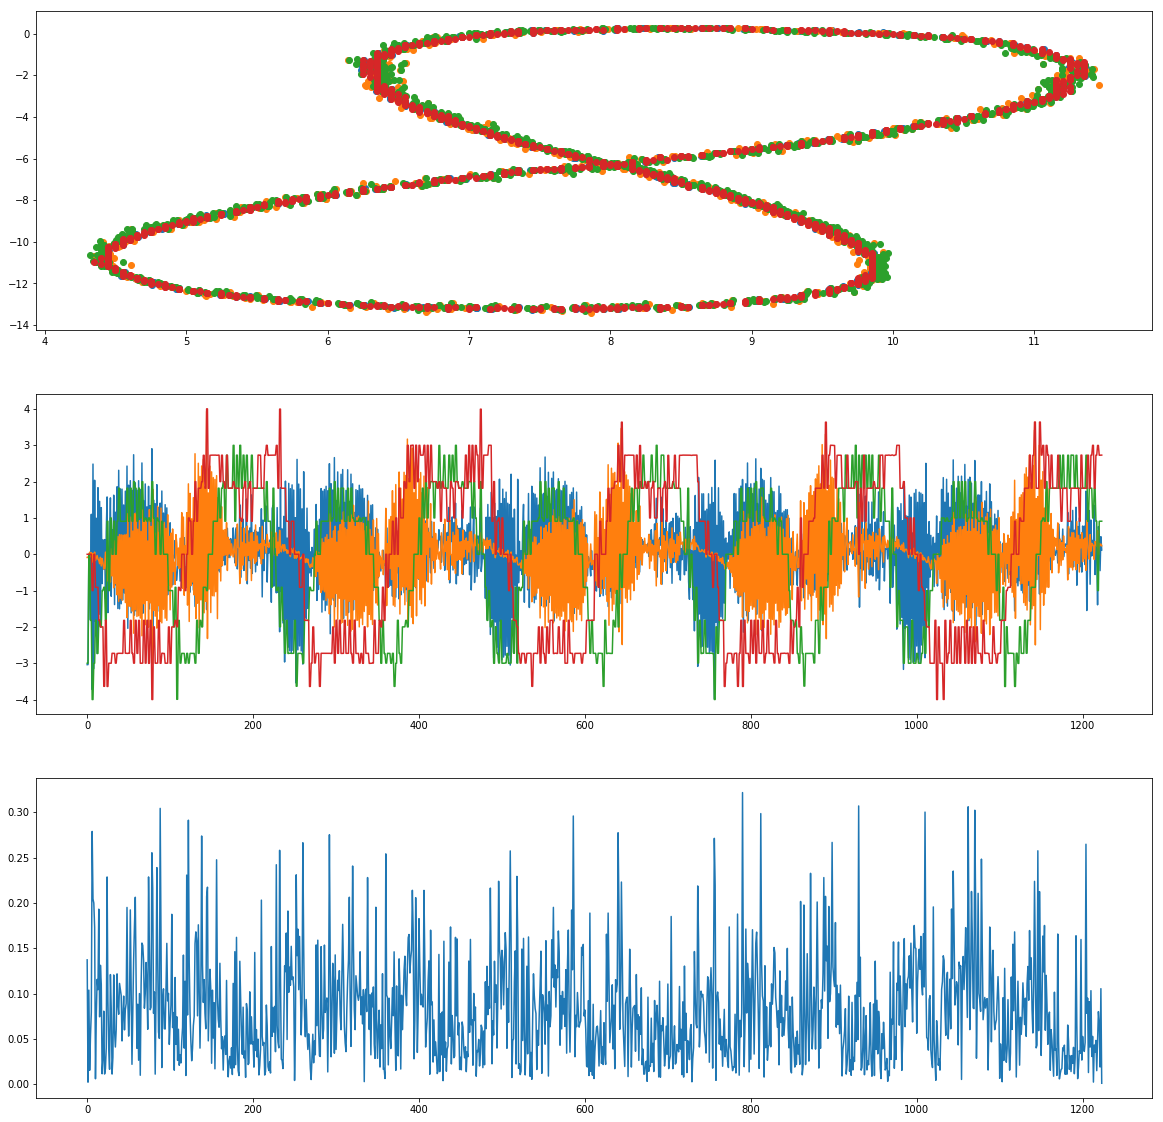

In [113]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.scatter(l_meas_list[:,0], l_meas_list[:,1])
plt.scatter(r_meas_list[:,0], r_meas_list[:,1])
plt.scatter(pred_list[:,0][:], pred_list[:,1][:])
plt.scatter(truth_list[:,0], truth_list[:,1])

plt.subplot(3,1,2)
plt.plot(pred_list[:,2])
plt.plot(pred_list[:,3])
plt.plot(truth_list[:,2])
plt.plot(truth_list[:,3])

plt.subplot(3,1,3)
plt.plot(RMSE)
